<a href="https://colab.research.google.com/github/Joshua-Woodard/SkimLit_NLP/blob/main/SkimLit_NLP_M2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build and NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset) is available here: https://www.arxiv-vanity.com/papers/1710.06071/

Reading through the paper above, we see that the model architecture th at they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

The ground truth notebook with text annotations and diagrams is on the course GitHub!

In [ ]:
## Confirm access to a GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5ebce270-26ad-c9d9-5053-54e6b847df0b)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed_rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
ls: cannot access 'pubmed_rct': No such file or directory


In [ ]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with the numbers replaced by "@"
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data!

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, Visualize, Visualize!

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines': 11},
   ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line, extracting target label, text of the sentence, how many sentences are in the abstract, and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # Check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
      
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 474 ms, sys: 111 ms, total: 585 ms
Wall time: 595 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
# Turn into dataframe to further visualize data
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

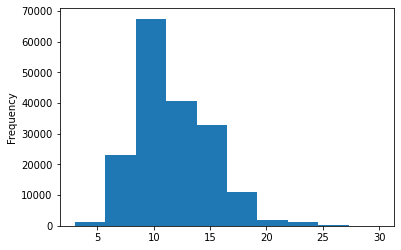

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [ ]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make Numeric Labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [ ]:
# extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

As as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).


## Model 0: Getting a baseline

In [ ]:
 from sklearn.feature_extraction.text import TfidfVectorizer
 from sklearn.naive_bayes import MultinomialNB
 from sklearn.pipeline import Pipeline

 # Create a pipeline
 model_0 = Pipeline([
                     ("tf-idf", TfidfVectorizer()),
                     ("clf", MultinomialNB())
 ])

 # Fit the pipeline to the training data
 model_0.fit(X=train_sentences,
             y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall, f1) and rather than rewriting it, let's just download it form the helper function script: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-27 19:16:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-27 19:16:58 (67.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

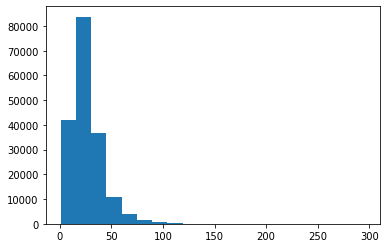

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

## Create Text Vectorization layer

In [ ]:
# How many words in our vocab (taken from table 2)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, #number of words in vocab
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
group @ consisted of @ men and @ women with a mean age of @ years , and mean hospital stay was @ days .

Length of text: 103

Vectorized text: [[  13 1007    4  309    3   90    7    8   57  103    4   64    3   57
   237  603   10   84    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# get the config of text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # different output dims can result in dramatically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 group @ consisted of @ men and @ women with a mean age of @ years , and mean hospital stay was @ days .
Sentence after vectorization (before embedding):
 [[  13 1007    4  309    3   90    7    8   57  103    4   64    3   57
   237  603   10   84    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.04909312  0.03897785 -0.02136124 ... -0.03023025 -0.03636869
   -0.02395265]
  [ 0.0368267  -0.00282128 -0.01585271 ...  0.03627855  0.04772273
    0.04918969]
  [ 0.04575621 -0.04580822 -0.01981292 ... -0.04300974  0.03591797
   -0.01183581]
  ...
  [ 0.04236095  0.02553538  0.0258531  ...  0.01942606 -0.01400771
    0.04926563]
  [ 0.04236095  0.02553538  0.0258531  ...  0.01942606 -0.01400771
    0.04926563]
  [ 0.04236095  0.02553538  0.0258531  ...  0.01942606 -0.01400771
    0.0492656

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with the token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 19s 8ms/step - loss: 0.9094 - accuracy: 0.6406 - val_loss: 0.6882 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6634 - accuracy: 0.7494 - val_loss: 0.6381 - val_accuracy: 0.7650
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6213 - accuracy: 0.7711 - val_loss: 0.6003 - val_accuracy: 0.7839


In [ ]:
# Evaluate on val data
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6020 - accuracy: 0.7856


[0.601952075958252, 0.7855818867683411]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.0098926e-01, 1.9303091e-01, 7.0046537e-02, 3.0819321e-01,
         2.7740194e-02],
        [4.6319735e-01, 2.7538559e-01, 1.0839817e-02, 2.4408753e-01,
         6.4896895e-03],
        [1.7825662e-01, 8.0576576e-03, 2.0350784e-03, 8.1160939e-01,
         4.1193871e-05],
        ...,
        [5.5013265e-06, 7.9929258e-04, 7.8667002e-04, 6.5823483e-06,
         9.9840194e-01],
        [4.9054421e-02, 5.1556784e-01, 8.4657662e-02, 5.9241362e-02,
         2.9147875e-01],
        [1.5436639e-01, 6.9318229e-01, 4.7612261e-02, 4.5134701e-02,
         5.9704293e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.55818879915265,
 'f1': 0.7831783191876731,
 'precision': 0.7827265672078174,
 'recall': 0.7855818879915265}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE)

The paper originally used GloVe embeddings, however we're going to stick with the later created USE pretrained embeddings.

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 we also examined memantine 's effect on caregiver burden .
Sentence after embedding:
[ 0.01701455  0.05741535 -0.0107037  -0.02981785 -0.01882977  0.04101041
 -0.03818473 -0.08161333  0.07798453  0.02924891  0.0884615   0.05410268
 -0.01660765  0.0897522  -0.01085065 -0.05160104 -0.09827422 -0.00147979
 -0.05680989 -0.03341381 -0.07842319  0.04356671  0.05213903 -0.0253888
  0.04584051  0.05057988  0.00235008 -0.02566371  0.08707201  0.0063582 ]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings from Tensorflow Hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted
outputs = layers.Dense(5, activation="softmax")(x) # create output layer
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 17ms/step - loss: 0.9160 - accuracy: 0.6479 - val_loss: 0.7984 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7685 - accuracy: 0.7011 - val_loss: 0.7562 - val_accuracy: 0.7028
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7515 - accuracy: 0.7124 - val_loss: 0.7396 - val_accuracy: 0.7128


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7406 - accuracy: 0.7145


[0.740606427192688, 0.7144843339920044]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[4.5796385e-01, 3.4491521e-01, 2.3448193e-03, 1.8713379e-01,
        7.6423627e-03],
       [3.4422171e-01, 4.8272136e-01, 3.8585565e-03, 1.6655873e-01,
        2.6396553e-03],
       [2.4527763e-01, 1.5878285e-01, 2.0607794e-02, 5.3797722e-01,
        3.7354521e-02],
       ...,
       [1.3603463e-03, 5.0773923e-03, 5.6593161e-02, 8.4478024e-04,
        9.3612432e-01],
       [4.0917331e-03, 4.6512768e-02, 2.2697476e-01, 1.5535207e-03,
        7.2086722e-01],
       [2.0227851e-01, 2.5351062e-01, 4.6970320e-01, 6.1315671e-03,
        6.8376094e-02]], dtype=float32)

In [ ]:
# Convert prediction probs to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.44843108698531,
 'f1': 0.7117040564276013,
 'precision': 0.7145272588197136,
 'recall': 0.7144843108698531}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
model_1_results

{'accuracy': 78.55818879915265,
 'f1': 0.7831783191876731,
 'precision': 0.7827265672078174,
 'recall': 0.7855818879915265}

## Model 3: Conv1D with Character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've used token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.


## Creating a character-level tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(random_train_sentence)

"w e   a l s o   e x a m i n e d   m e m a n t i n e   ' s   e f f e c t   o n   c a r e g i v e r   b u r d e n   ."

In [ ]:
# Split sequence level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

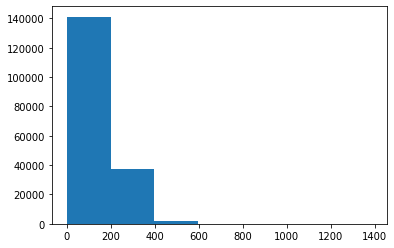

In [ ]:
# Check the distribution of our sequence at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what char length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# get all keyboard chars
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, "[UNK]")
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 p a r t i c i p a n t s   a r e   b l i n d e d   t o   t r e a t m e n t   a l l o c a t i o n   .

Length of random_train_chars: 44

Vectorized chars:
 [[14  5  8  3  4 11  4 14  5  6  3  9  5  8  2 22 12  4  6 10  2 10  3  7
   3  8  2  5  3 15  2  6  3  5 12 12  7 11  5  3  4  7  6  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  

## Create char-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # size of char embedding in paper (figure 1)
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 p a r t i c i p a n t s   a r e   b l i n d e d   t o   t r e a t m e n t   a l l o c a t i o n   .

Embedded chars. (after vectorization and embedding):
 [[[-0.01462406 -0.04757852  0.02734384 ...  0.00277033 -0.02256711
    0.04140583]
  [ 0.04682659  0.00608408 -0.01271176 ... -0.00936542  0.03898165
    0.01885209]
  [ 0.02155418  0.02198166 -0.02756764 ...  0.03005758  0.02699268
    0.03863969]
  ...
  [-0.03344266  0.01709611  0.0466775  ... -0.00275061  0.04284165
    0.04379657]
  [-0.03344266  0.01709611  0.0466775  ... -0.00275061  0.04284165
    0.04379657]
  [-0.03344266  0.01709611  0.0466775  ... -0.00275061  0.04284165
    0.04379657]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2584 - accuracy: 0.4957 - val_loss: 1.0319 - val_accuracy: 0.6041
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9955 - accuracy: 0.6076 - val_loss: 0.9402 - val_accuracy: 0.6343
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9206 - accuracy: 0.6350 - val_loss: 0.8681 - val_accuracy: 0.6649


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.18751761, 0.36967972, 0.07250137, 0.3179567 , 0.05234456],
       [0.13109085, 0.6844262 , 0.01391836, 0.09200188, 0.07856269],
       [0.1912285 , 0.2986488 , 0.09389836, 0.25031936, 0.16590498],
       ...,
       [0.00669536, 0.01677687, 0.12152988, 0.02399549, 0.8310024 ],
       [0.03327268, 0.14079243, 0.3422237 , 0.03514588, 0.44856533],
       [0.49068123, 0.29086098, 0.07682301, 0.12872836, 0.01290644]],
      dtype=float32)

In [ ]:
# Convert predictions to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [ ]:
# Calculate results for Conv1d model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.86124718654838,
 'f1': 0.6471333637400375,
 'precision': 0.6526610124240108,
 'recall': 0.6586124718654839}

## Model 4 : Combining pretrained token embeddings + characters embeddings (hybrid)

1. Create token-level embedding model (model 1)
2. Create char-level model (similar to model 3 with slight modification)
3. Combine the two models using `layers.Concatenate` : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 in the paper
5. Construct a model which takes token and character level sequences as intput and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in figure 1 of paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Combine the two models using layers.Concatenate ( creates hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 in paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

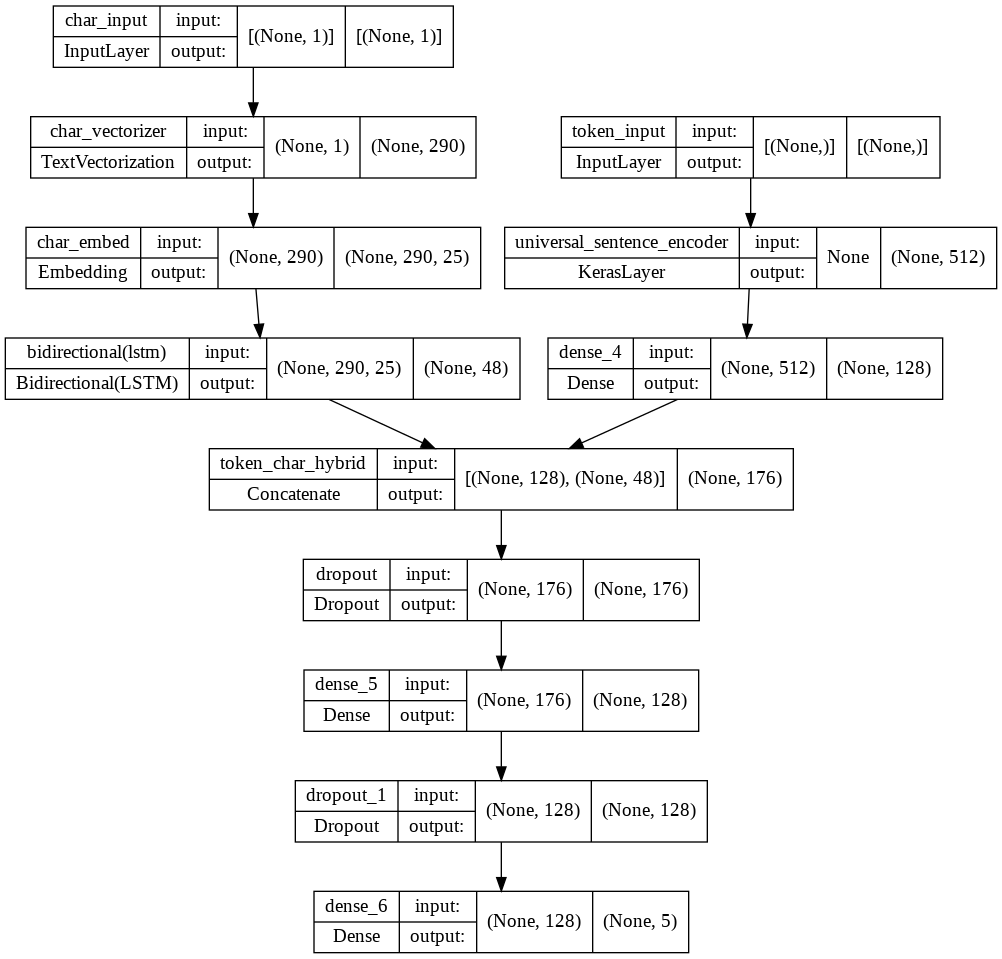

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 uses SGD
                metrics=["accuracy"])

## Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on token and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 48s 66ms/step - loss: 0.9792 - accuracy: 0.6115 - val_loss: 0.7721 - val_accuracy: 0.7048
Epoch 2/3
562/562 [==============================] - 32s 58ms/step - loss: 0.7967 - accuracy: 0.6906 - val_loss: 0.7085 - val_accuracy: 0.7347
Epoch 3/3
562/562 [==============================] - 29s 52ms/step - loss: 0.7691 - accuracy: 0.7057 - val_loss: 0.6952 - val_accuracy: 0.7443


In [ ]:
# Evaluate on whole val dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 26s 28ms/step - loss: 0.6995 - accuracy: 0.7358


[0.6995322704315186, 0.735833466053009]

In [ ]:
# Make preds using token_char model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.2236817e-01, 3.6967176e-01, 4.0300637e-03, 1.9644395e-01,
        7.4861120e-03],
       [3.2597211e-01, 4.6128434e-01, 3.0985766e-03, 2.0718683e-01,
        2.4581263e-03],
       [2.7629763e-01, 1.5367305e-01, 5.2763693e-02, 4.7990924e-01,
        3.7356321e-02],
       ...,
       [1.3646128e-03, 1.2240824e-02, 7.7689484e-02, 7.4515241e-04,
        9.0795994e-01],
       [4.7758264e-03, 5.2977994e-02, 2.4797800e-01, 3.3275126e-03,
        6.9094062e-01],
       [2.9706505e-01, 2.9110247e-01, 2.8798658e-01, 3.2740992e-02,
        9.1104984e-02]], dtype=float32)

In [ ]:
# Convert preds to labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.5833443664769,
 'f1': 0.7336336248278532,
 'precision': 0.7368035656428323,
 'recall': 0.735833443664769}

## Model 5; Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> Note 👿 Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

## Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

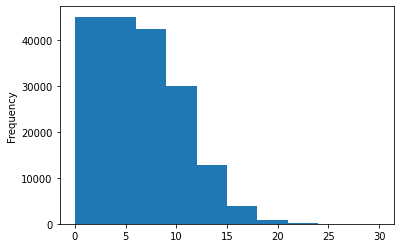

In [ ]:
# check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [ ]:
val_df["line_number"], val_df["total_lines"]

(0         0
 1         1
 2         2
 3         3
 4         4
          ..
 30207     9
 30208    10
 30209    11
 30210    12
 30211    13
 Name: line_number, Length: 30212, dtype: int64, 0         9
 1         9
 2         9
 3         9
 4         9
          ..
 30207    13
 30208    13
 30209    13
 30210    13
 30211    13
 Name: total_lines, Length: 30212, dtype: int64)

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

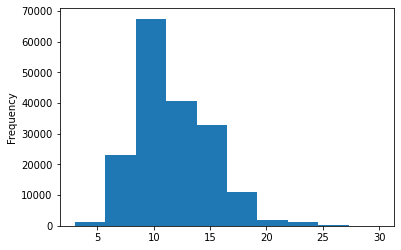

In [ ]:
# Check distributions of total lines
train_df["total_lines"].plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use tensorflow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot, train_total_lines_one_hot[:10]

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.

### Building a tri-brid embedding model

1. Create token-level model
2. Create character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine 3, 4, & 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and the outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. "line_number" feature model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# 4. "total_lines" feature model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# 5. Combine the outputs of Token model and Char model using concatenate into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine line_number, total_lines, and combined hybrid embeddings 
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embeddings")([line_number_model.output,
                                                                                  total_lines_model.output,
                                                                                  z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all inputs!
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
# Get a summary of our tribrid model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

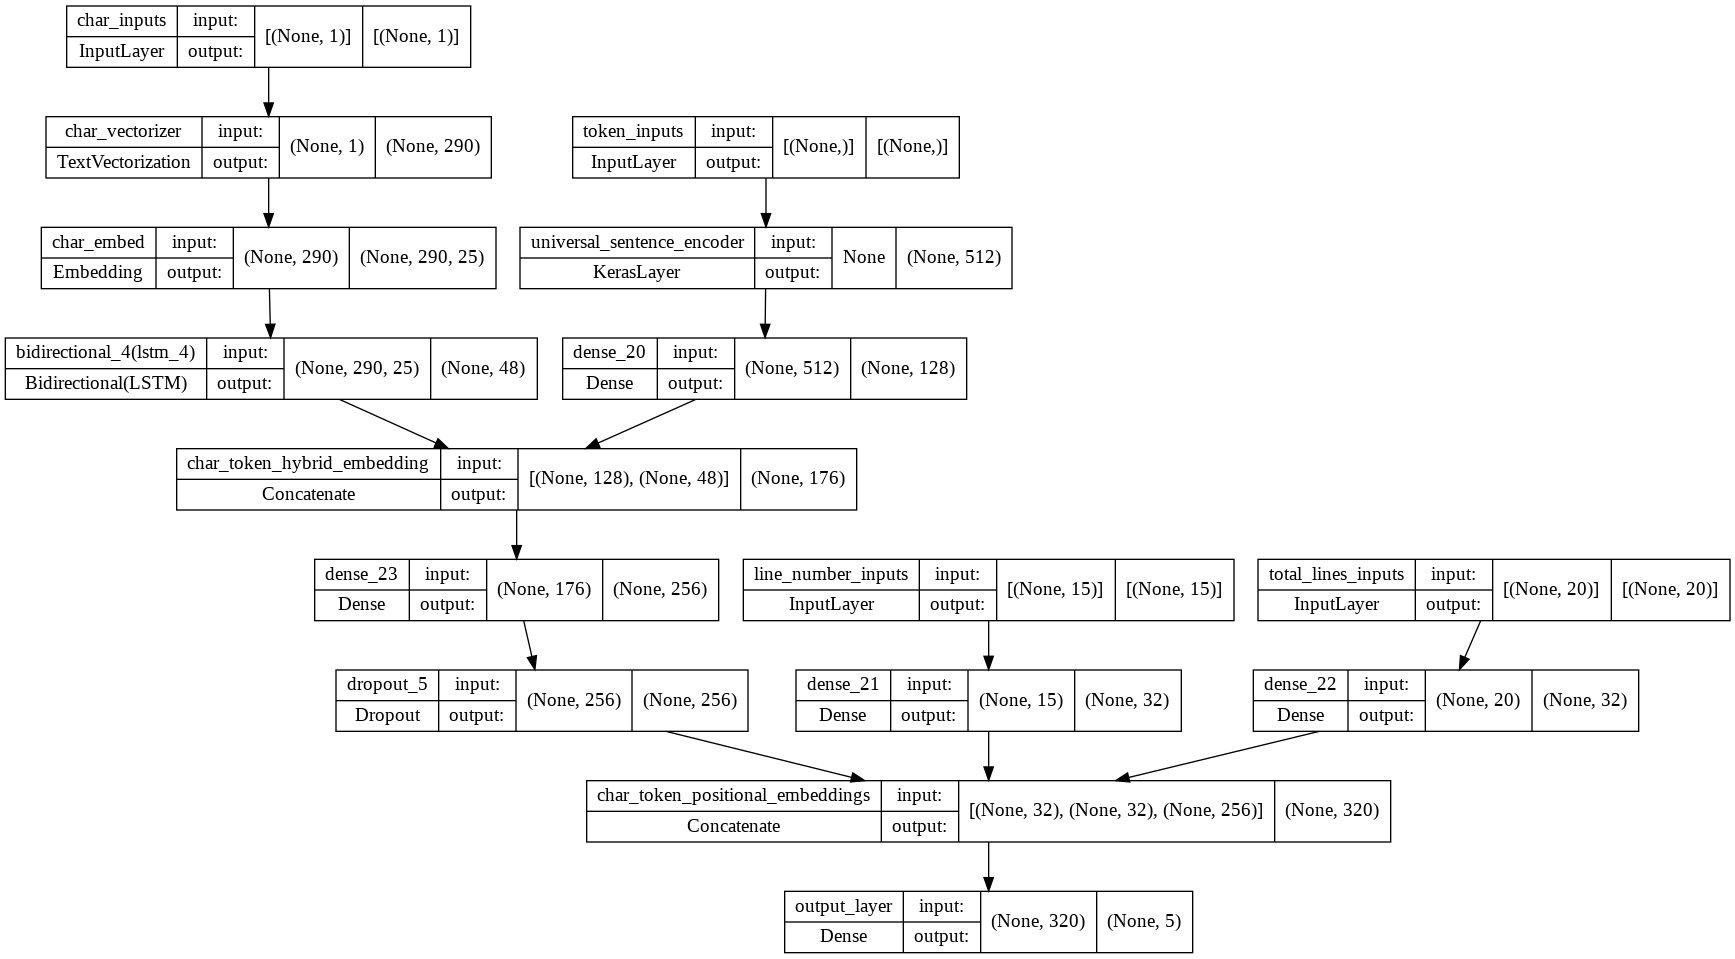

In [ ]:
# Plot tribrid model
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes. In turn, hopefully improving generalization.

This could look like: `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [ ]:
# Compile token, char, and positional embedding model
model_5. compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [ ]:
np.shape(val_chars), np.shape(train_total_lines_one_hot)

((30212,), TensorShape([180040, 20]))

In [ ]:
# create training and validation dataset (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting, evaluating, and making predictions with our tribrid model

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data= val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 80s 109ms/step - loss: 1.0967 - accuracy: 0.7245 - val_loss: 0.9814 - val_accuracy: 0.8065
Epoch 2/3
562/562 [==============================] - 57s 102ms/step - loss: 0.9672 - accuracy: 0.8156 - val_loss: 0.9502 - val_accuracy: 0.8305
Epoch 3/3
562/562 [==============================] - 52s 92ms/step - loss: 0.9504 - accuracy: 0.8217 - val_loss: 0.9402 - val_accuracy: 0.8321


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 49s 46ms/step


array([[0.49451342, 0.1036816 , 0.01065036, 0.37185192, 0.01930267],
       [0.5225028 , 0.1220656 , 0.05216943, 0.29438424, 0.00887799],
       [0.26296464, 0.10254854, 0.13397095, 0.43457666, 0.06593915],
       ...,
       [0.03312162, 0.09434623, 0.04224622, 0.03184028, 0.7984457 ],
       [0.02896935, 0.25501624, 0.07785962, 0.02334517, 0.61480963],
       [0.22862768, 0.5737452 , 0.10859247, 0.04015055, 0.0488841 ]],
      dtype=float32)

In [ ]:
# Convert pred probs to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results on char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.2318284125513,
 'f1': 0.831525873351788,
 'precision': 0.8312820037097317,
 'recall': 0.832318284125513}

In [ ]:
model_4_results

{'accuracy': 73.5833443664769,
 'f1': 0.7336336248278532,
 'precision': 0.7368035656428323,
 'recall': 0.735833443664769}

## Compare model results 

Far out, we've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.448961,0.781494,0.784490,0.782299
pretrained_token_embed,71.425261,0.714881,0.714253,0.711455
custom_char_embed_conv1d,65.877797,0.654501,0.658778,0.651686
hybrid_char_token_embed,73.623064,0.737075,0.736231,0.733561
tribrid_pos_char_token_embed,82.612869,0.824449,0.826129,0.825037


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

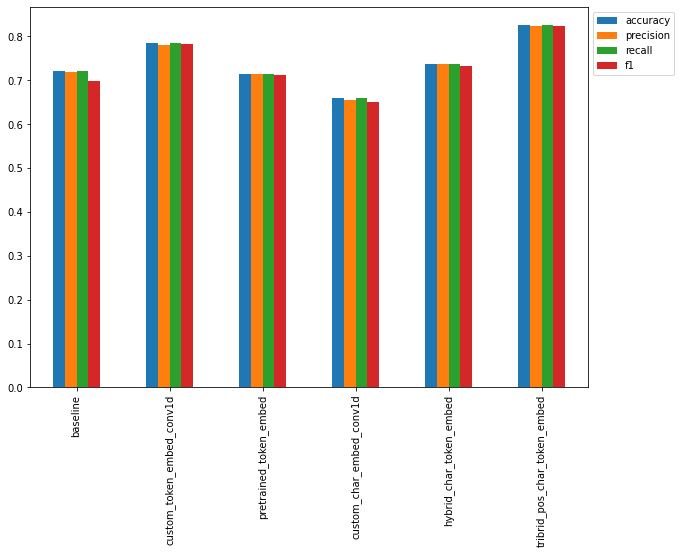

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Since the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper compares their tested model's F1-scores on the test dataset, let's take at our model's F1-scores.

> 🔑 **Note:** We could've also made these comparisons in TensorBoard using the [`TensorBoard`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) callback during training.

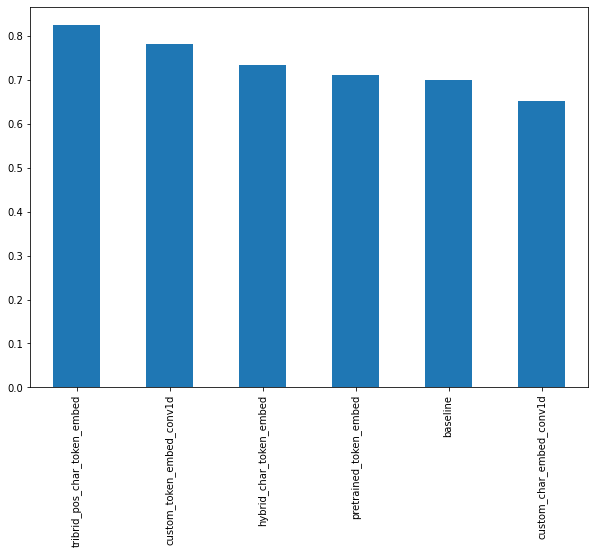

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Nice! Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

Though, in comparison to the results reported in Table 3 of the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

There are some things to note about this difference:
* Our models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.
  * This is often the case in machine learning experiments though, make sure training works on a smaller number of samples, then upscale when needed (an extension to this project will be training a model on the full dataset).
* Our model's prediction performance levels have been evaluated on the validation dataset not the test dataset (we'll evaluate our best model on the test dataset shortly).

## Save and load best performing model

Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain it.

We can save our best performing model by calling the [`save()`](https://www.tensorflow.org/guide/keras/save_and_serialize#the_short_answer_to_saving_loading) method on it.

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


Optional: If you're using Google Colab, you might want to copy your saved model to Google Drive (or [download it](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=hauvGV4hV-Mh)) for more permanent storage (Google Colab files disappear after you disconnect).

In [ ]:
# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skim_lit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit


Like all good cooking shows, we've got a pretrained model (exactly the same kind of model we built for `model_5` [saved and stored on Google Storage](https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_best_model.zip)). 

So to make sure we're all using the same model for evaluation, we'll download it and load it in. 

And when loading in our model, since it uses a couple of [custom objects](https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects) (our TensorFlow Hub layer and `TextVectorization` layer), we'll have to load it in by specifying them in the `custom_objects` parameter of [`tf.keras.models.load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model). 



In [ ]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2021-08-25 00:03:10--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  40.9MB/s    in 12s     

2021-08-25 00:03:23 (74.5 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_

In [ ]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file 
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

### Make predictions and evalaute them against the truth labels

To make sure our model saved and loaded correctly, let's make predictions with it, evaluate them and then compare them to the prediction results we calculated earlier.

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 132s 139ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 82.74526678141136,
 'f1': 0.8264355957043299,
 'precision': 0.8258640600563426,
 'recall': 0.8274526678141136}

Now let's compare our loaded model's predictions with the prediction results we obtained before saving our model.

In [ ]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

It's worth noting that loading in a SavedModel unfreezes all layers (makes them all trainable). So if you want to freeze any layers, you'll have to set their trainable attribute to `False`.

In [ ]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, None)         0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, None, 25)     1750        char_vectorizer[0][0]            
____________________________________________________________________________________________

## Evaluate model on test dataset

To make our model's performance more comparable with the results reported in Table 3 of the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper, let's make predictions on the test dataset and evaluate them.

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 132s 140ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.39588518334163,
 'f1': 0.8229369808171064,
 'precision': 0.8225726116113812,
 'recall': 0.8239588518334163}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

## Find most wrong

One of the best ways to investigate where your model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

Let's write some code to help us visualize the most wrong predictions from the test dataset.

First we'll convert all of our integer-based test predictions into their string-based class names.

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 10.2 s, sys: 856 ms, total: 11.1 s
Wall time: 9.42 s


Now we'll enrich our test DataFame with a few values:
* A `"prediction"` (string) column containing our model's prediction for a given sample.
* A `"pred_prob"` (float) column containing the model's maximum prediction probabiliy for a given sample.
* A `"correct"` (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.513077,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.310540,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.801705,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.627319,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.718288,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.879730,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.548948,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.445276,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.529703,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.545452,True


Looking good! Having our data like this, makes it very easy to manipulate and view in different ways.

How about we sort our DataFrame to find the samples with the highest `"pred_prob"` and where the prediction was wrong (`"correct" == False`)?

In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.944838,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.941099,False
1221,RESULTS,data were collected prospectively for @ months...,3,13,METHODS,0.928523,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.918107,False
21382,OBJECTIVE,"design , settings , participants , and interve...",3,13,METHODS,0.918088,False
...,...,...,...,...,...,...,...
12269,RESULTS,patients received oral se tablets ( @ mcg ) or...,4,10,METHODS,0.821220,False
9881,RESULTS,"the primary outcome was bp control , and secon...",4,11,METHODS,0.821166,False
1220,RESULTS,the group intervention consisted of @ weekly c...,2,13,METHODS,0.821033,False
22105,RESULTS,we randomised @ statin treated cvd patients an...,3,12,METHODS,0.820954,False


Great (or not so great)! Now we've got a subset of our model's most wrong predictions, let's write some code to visualize them.

In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9448384046554565, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9410986304283142, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9285234808921814, Line number: 3, Total lines: 13

Text:
data were collected prospectively for @ months beginning after completion of the first @ group clinic appointments ( @ months post randomization ) .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9181066155433655, Line number: 6, Total lines: 9

Text:
-@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups .

-----

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9180881381034851, Line number: 3, Total lines: 13

Text:
design , settings , participants , 

What do you notice about the most wrong predictions? Does the model make silly mistakes? Or are some of the labels incorrect/ambiguous (e.g. a line in an abstract could potentially be labelled `OBJECTIVE` or `BACKGROUND` and make sense).

A next step here would be if there are a fair few samples with inconsistent labels, you could go through your training dataset, update the labels and then retrain a model. The process of using a model to help improve/investigate your dataset's labels is often referred to as **active learning**.

## Make example predictions

Okay, we've made some predictions on the test dataset, now's time to really test our model out.

To do so, we're going to get some data from the wild and see how our model performs.

In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

For an appropriate sample, we'll need to search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed you'll notice many of the abstracts are already preformatted into separate sections, this helps dramatically with readability).

Going through various PubMed studies, I managed to find the following unstructured abstract from [*RCT of a manualized social treatment for high-functioning autism spectrum disorders*](https://pubmed.ncbi.nlm.nih.gov/20232240/):

> This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

Looking at the large chunk of text can seem quite intimidating. Now imagine you're a medical researcher trying to skim through the literature to find a study relevant to your work.

Sounds like quite the challenge right?

Enter SkimLit 🤓🔥!

Let's see what our best model so far (`model_5`) makes of the above abstract.

But wait...

As you might've guessed the above abstract hasn't been formatted in the same structure as the data our model has been trained on. Therefore, before we can make a prediction on it, we need to preprocess it just as we have our other sequences.

More specifically, for each abstract, we'll need to:

1. Split it into sentences (lines).
2. Split it into characters.
3. Find the number of each line.
4. Find the total number of lines.

Starting with number 1, there are a couple of ways to split our abstracts into actual sentences. A simple one would be to use Python's in-built `split()` string method, splitting the abstract wherever a fullstop appears. However, can you imagine where this might go wrong? 

Another more advanced option would be to leverage [spaCy's](https://spacy.io/) (a very powerful NLP library) [`sentencizer`](https://spacy.io/usage/linguistic-features#sbd) class. Which is an easy to use sentence splitter based on spaCy's English language model.

I've prepared some abstracts from PubMed RCT papers to try our model on, we can download them [from GitHub](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json).


In [ ]:
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2021-08-25 00:08:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2021-08-25 00:08:37 (82.5 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



NameError: ignored

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

Now we've downloaded some example abstracts, let's see how one of them goes with our trained model.

First, we'll need to parse it using spaCy to turn it from a big chunk of text into sentences.

In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

Beautiful! It looks like spaCy has split the sentences in the abstract correctly. However, it should be noted, there may be more complex abstracts which don't get split perfectly into separate sentences (such as the example in [*Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection*](https://pubmed.ncbi.nlm.nih.gov/22244707/)), in this case, more custom splitting techniques would have to be investigated.

Now our abstract has been split into sentences, how about we write some code to count line numbers as well as total lines.

To do so, we can leverage some of the functionality of our `preprocess_text_with_line_numbers()` function.

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

Now we've got `"line_number"` and `"total_lines"` values, we can one-hot encode them with `tf.one_hot` just like we did with our training dataset (using the same values for the `depth` parameter).

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

We can also use our `split_chars()` function to split our abstract lines into characters.

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

Alright, now we've preprocessed our wild RCT abstract into all of the same features our model was trained on, we can pass these features to our model and make sequence label predictions!

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

Now we've got the predicted sequence label for each line in our sample abstract, let's write some code to visualize each sentence with its predicted label.

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

Nice! Isn't that much easier to read? I mean, it looks like our model's predictions could be improved, but how cool is that?

Imagine implementing our model to the backend of the PubMed website to format any unstructured RCT abstract on the site.

Or there could even be a browser extension, called "SkimLit" which would add structure (powered by our model) to any unstructured RCT abtract.

And if showed your medical researcher friend, and they thought the predictions weren't up to standard, there could be a button saying "is this label correct?... if not, what should it be?". That way the dataset, along with our model's future predictions, could be improved over time.

Of course, there are many more ways we could go to improve the model, the usuability, the preprocessing functionality (e.g. functionizing our sample abstract preprocessing pipeline) but I'll leave these for the exercises/extensions.

> 🤔 **Question:** How can we be sure the results of our test example from the wild are truly *wild*? Is there something we should check about the sample we're testing on?

## 📖 Extra-curriculum
* For more on working with text/spaCy, see [spaCy's advanced NLP course](https://course.spacy.io/en/). If you're going to be working on production-level NLP problems, you'll probably end up using spaCy.
* For another look at how to approach a text classification problem like the one we've just gone through, I'd suggest going through [Google's Machine Learning Course for text classification](https://developers.google.com/machine-learning/guides/text-classification). 
* Since our dataset has imbalanced classes (as with many real-world datasets), so it might be worth looking into the [TensorFlow guide for different methods to training a model with imbalanced classes](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
